## In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import sklearn

### Loading Data

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
print train.shape
train.head(2)
    

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [5]:
full_data=[train,test]

In [6]:
for data in full_data:
    data['date']=data['datetime'].apply(lambda x: x.split()[0])
    data['hour']=data['datetime'].apply(lambda x: x.split()[1].split(':')[0])

In [7]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01


In [8]:
for data in full_data:
    data['year']=data['date'].apply(lambda x:x.split('-')[0])
    data['month']=data['date'].apply(lambda x:x.split('-')[1])
    data['day']=data['date'].apply(lambda x:x.split('-')[2])

In [9]:
del train['datetime']
del test['datetime']
del train['date']
del test['date']

In [10]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,day
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00,2011,01,01
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01,2011,01,01
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02,2011,01,01
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03,2011,01,01
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04,2011,01,01


In [11]:
for data in full_data:
    data['weekend']=0
for data in full_data:
    data.loc[(data.holiday==0) & (data.workingday==0),'weekend']=1    

In [12]:
train.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
hour           object
year           object
month          object
day            object
weekend         int64
dtype: object

In [13]:
for col in ['season','holiday','workingday','weather','hour','year','day','month','weekend']:
    train[col]=train[col].astype('category')
    test[col]=test[col].astype('category')

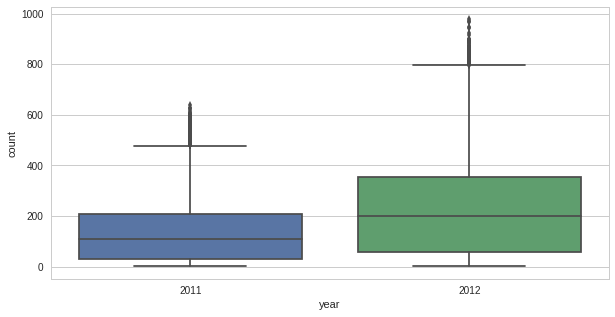

In [14]:
plt.figure(figsize=(10,5))
sn.set_style(style='whitegrid')
sn.boxplot(data=train,x='year',y='count')

Axes(0.125,0.125;0.775x0.755)


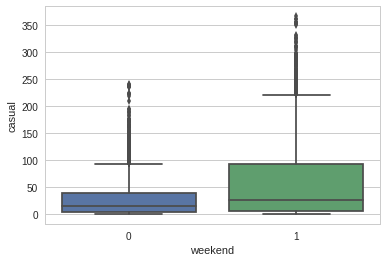

In [15]:
print sn.boxplot(data=train,x='weekend',y='casual')
plt.show()

Creating new seperate features for casual and registered by binning hour according to count

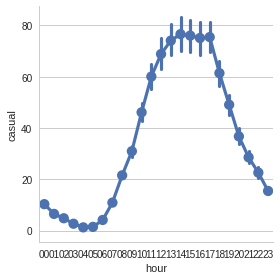

In [16]:
plt.figure(figsize=(10,5))
sn.factorplot(x='hour',y='casual',data=train)
plt.show()

In [17]:

for data in full_data:
    data['hour']=data['hour'].astype('int64')
    data['hour_cs']=0
    data.loc[data['hour']<=7,'hour_cs']=1
    data.loc[(data['hour']>=8) & (data['hour']<=11),'hour_cs']=2
    data.loc[(data['hour']>=10) & (data['hour']<=17),'hour_cs']=3
    data.loc[(data['hour']>=18),'hour_cs']=2
    data['hour_cs']=data['hour_cs'].astype('category')

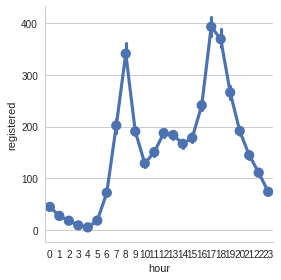

In [18]:
sn.factorplot(x='hour',y='registered',data=train)

In [19]:
for data in full_data:
    data['hour_cr']=0
    data.loc[data['hour']<=6,'hour_cr']=1
    data.loc[(data['hour']>=7) & (data['hour']<=10),'hour_cr']=3
    data.loc[(data['hour']>=11) & (data['hour']<=16),'hour_cr']=2
    data.loc[(data['hour']>=17) & (data['hour']<=20),'hour_cr']=3
    data.loc[(data['hour']>=21),'hour_cr']=1
    data['hour_cr']=data['hour_cr'].astype('category')
    data['hour']=data['hour'].astype('category')

In [20]:
train.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
hour          category
year          category
month         category
day           category
weekend       category
hour_cs       category
hour_cr       category
dtype: object

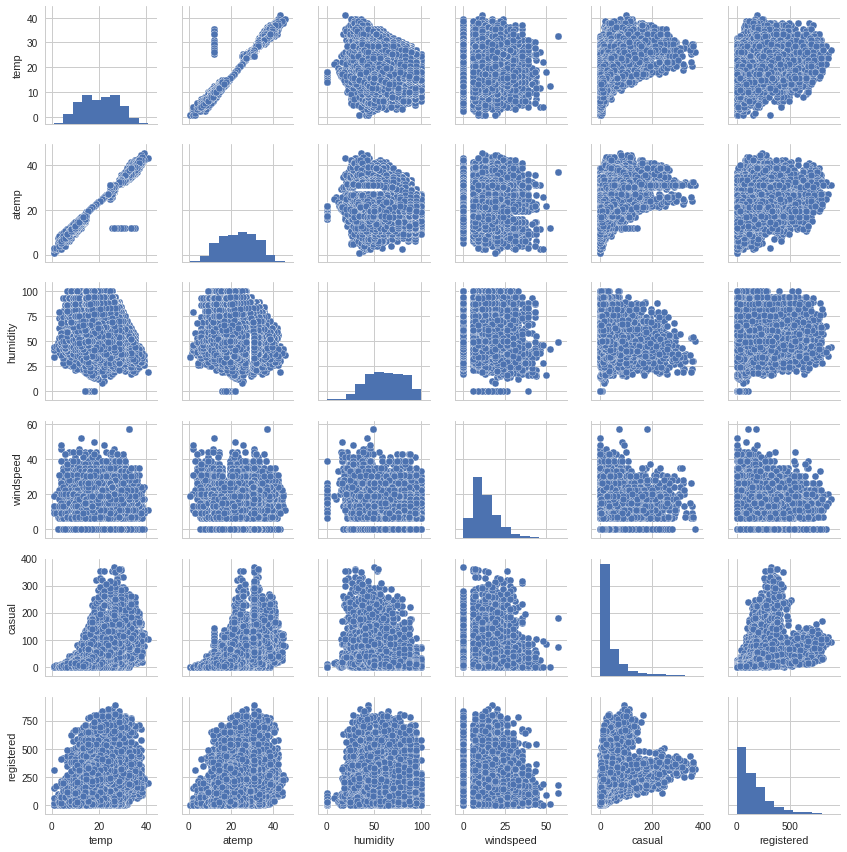

In [21]:
sn.pairplot(train[['temp','atemp','humidity','windspeed','casual','registered']],size=2)

dropping atemp

In [22]:
for data in full_data:
    data.drop('atemp',axis=1,inplace=True)

In [23]:
train.shape

(10886, 17)

In [24]:
train.columns

Index([u'season', u'holiday', u'workingday', u'weather', u'temp', u'humidity',
       u'windspeed', u'casual', u'registered', u'count', u'hour', u'year',
       u'month', u'day', u'weekend', u'hour_cs', u'hour_cr'],
      dtype='object')

In [25]:
features_cs=['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'hour', 'year','day','month', 'weekend', 'hour_cs']
features_cr=['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'hour', 'year','day','month', 'weekend', 'hour_cr']

<function matplotlib.pyplot.hist>

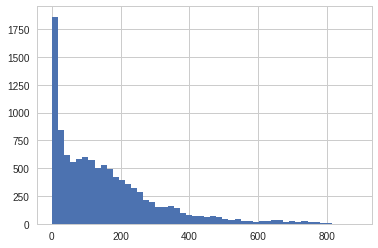

In [26]:
plt.hist(train.registered,bins=50)
plt.hist

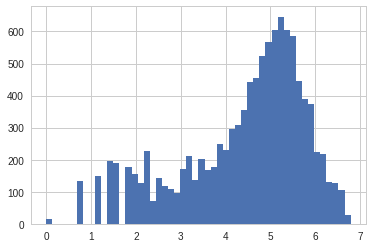

In [27]:
plt.hist(np.log(train.registered+1),bins=50)
plt.show()

Converting target variables registered and casual into log(a+1) form

In [28]:
train['target_cr']=np.log1p(train['registered']+1)
train['target_cs']=np.log1p(train['casual']+1)

In [29]:
def RMSLE(y,ypred):
    y=np.nan_to_num(y)
    ypred=np.nan_to_num(ypred)
    calc=(ypred-y)**2
    return np.sqrt(np.mean(calc))

### Modelling

In [34]:
from sklearn.model_selection import train_test_split
xtrain_cs,xtest_cs,ytrain_cs,ytest_cs=train_test_split(train[features_cs].values,np.ravel(train['target_cs'].values),test_size=0.25)
xtrain_cr,xtest_cr,ytrain_cr,ytest_cr=train_test_split(train[features_cr].values,np.ravel(train['target_cr'].values),test_size=0.25)

In [35]:
print xtrain_cs.shape
print xtest_cs.shape

(8164, 13)
(2722, 13)


In [36]:
from sklearn.model_selection import GridSearchCV

Linear Regression Model

In [37]:
from sklearn.preprocessing import StandardScaler
sc_1=StandardScaler()
sc_2=StandardScaler()
xtrain_cs_norm=sc_1.fit_transform(xtrain_cs)
xtest_cs_norm=sc_1.transform(xtest_cs)
xtrain_cr_norm=sc_2.fit_transform(xtrain_cr)
xtest_cr_norm=sc_2.transform(xtest_cr)

In [38]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [39]:
clf_1_cs=LinearRegression()
clf_1_cs.fit(xtrain_cs,ytrain_cs)
print "RMSLE score for casual train %f" %(RMSLE(ytrain_cs,clf_1_cs.predict(xtrain_cs)))
print "RMSLE score for casual test %f" %(RMSLE(ytest_cs,clf_1_cs.predict(xtest_cs)))

clf_1_cr=LinearRegression()
clf_1_cr.fit(xtrain_cr,ytrain_cr)
print "RMSLE score for registered train %f" %(RMSLE(ytrain_cr,clf_1_cr.predict(xtrain_cr)))
print "RMSLE score for registered test %f" %(RMSLE(ytest_cr,clf_1_cr.predict(xtest_cr)))

RMSLE score for casual train 0.672264
RMSLE score for casual test 0.662786
RMSLE score for registered train 0.763042
RMSLE score for registered test 0.758600


In [43]:
clf_2_cs=Ridge()
params={'alpha':[0.05,0.1,0.5,1,2,3,4,10]}
rmsle_scorer=sklearn.metrics.make_scorer(RMSLE,greater_is_better=False)
grid_2_cs=GridSearchCV(clf_2_cs,param_grid=params,scoring=rmsle_scorer,cv=5)
grid_2_cs.fit(xtrain_cs,ytrain_cs)
print ("Best params", grid_2_cs.best_params_)
print "RMSLE score for casual train %f" %(RMSLE(ytrain_cs,grid_2_cs.best_estimator_.predict(xtrain_cs)))
print "RMSLE score for casual test %f" %(RMSLE(ytest_cs,grid_2_cs.best_estimator_.predict(xtest_cs)))

clf_2_cr=Ridge()
grid_2_cr=GridSearchCV(clf_2_cr,param_grid=params,scoring=rmsle_scorer,cv=5)
grid_2_cr.fit(xtrain_cr,ytrain_cr)
print ("Best params", grid_2_cr.best_params_)
print "RMSLE score for registered train %f" %(RMSLE(ytrain_cr,grid_2_cr.best_estimator_.predict(xtrain_cr)))
print "RMSLE score for registered test %f" %(RMSLE(ytest_cr,grid_2_cr.best_estimator_.predict(xtest_cr)))


('Best params', {'alpha': 4})
RMSLE score for casual train 0.672264
RMSLE score for casual test 0.662775
('Best params', {'alpha': 10})
RMSLE score for registered train 0.763044
RMSLE score for registered test 0.758597


In [42]:
clf_3_cs=Lasso()
params={'alpha': np.linspace(0.001,10,14)}
grid_3_cs=GridSearchCV(clf_2_cs,param_grid=params,scoring=rmsle_scorer,cv=5)
grid_3_cs.fit(xtrain_cs,ytrain_cs)
print ("Best params", grid_3_cs.best_params_)
print "RMSLE score for casual train %f" %(RMSLE(ytrain_cs,grid_3_cs.best_estimator_.predict(xtrain_cs)))
print "RMSLE score for casual test %f" %(RMSLE(ytest_cs,grid_3_cs.best_estimator_.predict(xtest_cs)))

clf_3_cr=Ridge()
grid_3_cr=GridSearchCV(clf_3_cr,param_grid=params,scoring=rmsle_scorer,cv=5)
grid_3_cr.fit(xtrain_cr,ytrain_cr)
print ("Best params", grid_3_cr.best_params_)
print "RMSLE score for registered train %f" %(RMSLE(ytrain_cr,grid_3_cr.best_estimator_.predict(xtrain_cr)))
print "RMSLE score for registered test %f" %(RMSLE(ytest_cr,grid_3_cr.best_estimator_.predict(xtest_cr)))


('Best params', {'alpha': 3.8467692307692309})
RMSLE score for casual train 0.672264
RMSLE score for casual test 0.662775
('Best params', {'alpha': 10.0})
RMSLE score for registered train 0.763044
RMSLE score for registered test 0.758597


In [44]:
from sklearn.ensemble import RandomForestRegressor
clf_4_cs=RandomForestRegressor()
param={'n_estimators':[100,200,300,400,500],'max_depth':[4,5,6,7,8,9,10]}
grid_4_cs=GridSearchCV(clf_4_cs,param_grid=param,scoring=rmsle_scorer,cv=5,n_jobs=4)
grid_4_cs.fit(xtrain_cs,ytrain_cs)
print ("Best params",grid_4_cs.best_params_)
print "RMSLE score for casual train %f" %(RMSLE(ytrain_cs,grid_4_cs.best_estimator_.predict(xtrain_cs)))
print "RMSLE score for casual test %f" %(RMSLE(ytest_cs,grid_4_cs.best_estimator_.predict(xtest_cs)))

clf_4_cr=RandomForestRegressor()
grid_4_cr=GridSearchCV(clf_4_cr,param_grid=param,scoring=rmsle_scorer,cv=5,n_jobs=4)
grid_4_cr.fit(xtrain_cr,ytrain_cr)
print ("Best params",grid_4_cr.best_params_)
print "RMSLE score for registered train %f" %(RMSLE(ytrain_cr,grid_4_cr.best_estimator_.predict(xtrain_cr)))
print "RMSLE score for registered test %f" %(RMSLE(ytest_cr,grid_4_cr.best_estimator_.predict(xtest_cr)))

('Best params', {'n_estimators': 500, 'max_depth': 10})
RMSLE score for casual train 0.314700
RMSLE score for casual test 0.438585
('Best params', {'n_estimators': 500, 'max_depth': 10})
RMSLE score for registered train 0.214855
RMSLE score for registered test 0.309128


In [45]:
scs_cs=StandardScaler()
scs_cr=StandardScaler()
train_cs_sd=scs_cs.fit_transform(train[features_cs].values)
train_cr_sd=scs_cr.fit_transform(train[features_cr].values)
test_cs_sd=scs_cs.transform(test[features_cs].values)
test_cr_sd=scs_cr.transform(test[features_cr].values)

In [46]:
clf_final_cs=RandomForestRegressor(n_estimators=300,max_depth=10)
clf_final_cr=RandomForestRegressor(n_estimators=300,max_depth=10)
clf_final_cs.fit(train_cs_sd,train['target_cs'].values)
clf_final_cr.fit(train_cr_sd,train['target_cr'].values)
pred_cs=(np.exp(clf_final_cs.predict(test_cs_sd)))-1
pred_cr=(np.exp(clf_final_cr.predict(test_cr_sd)))-1

In [47]:
pred_cs.shape

(6493,)

In [48]:
count=pred_cs+pred_cr
print count.shape

(6493,)


In [49]:
test1=pd.read_csv('test.csv')
submission_1=pd.DataFrame(test1['datetime'])
submission_1['count']=count
submission_1['count']=submission_1['count'].astype('int')
submission_1.head()

,datetime,count
0,2011-01-20 00:00:00,14
1,2011-01-20 01:00:00,7
2,2011-01-20 02:00:00,6
3,2011-01-20 03:00:00,4
4,2011-01-20 04:00:00,4


In [197]:
submission_1.to_csv('submission.csv')